## Assignment 2 - Exploration of patterns in the data

### Energy Demand based on time data

Energy Demand (Regression): Heavily dependant on seasonal patterns (time-of-day, day-of-week, time-of-year), and partly on weather

Descriptive model : Model the relationship between time and demand
Predictive model : Since predicting the time as a given time in the future is trivial, this is almost for free. Different types include Long-term Load Forecasting (months-ahead), Short-term Load Forecasting (day-head or week-ahead), and Ultra Short-term Load Forecasting (hours-ahead).

I have decided explore demand as a function of time features. I will first look at the 

In [1]:
# import what has to be
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from energy_gen_forecast import mytransformers
plt.style.use('seaborn')
%matplotlib inline

In [2]:
# create client
client = InfluxDBClient(host = 'influxus.itu.dk', port = 8086, username = 'lsda', password = 'icanonlyread')
client.switch_database('orkney')

In [3]:
client.get_list_measurements()

[{'name': 'ANM_Operation'},
 {'name': 'Demand'},
 {'name': 'Generation'},
 {'name': 'Generator_Site_Issues'},
 {'name': 'SHEPD_Equipment'},
 {'name': 'Temperature'},
 {'name': 'Wind'}]

In [4]:
# get demand data for exploration
results = client.query('SELECT Total FROM "Demand" WHERE time > now() - 200w')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_df = pd.DataFrame(values, columns = columns).set_index("time")

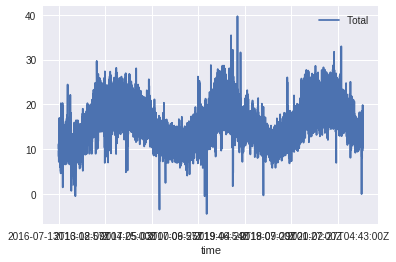

In [5]:
demand_df.plot()

In [6]:
demand_df.head()

,Total
time,
2016-07-13T13:08:57Z,9.58
2016-07-13T13:09:57Z,9.04
2016-07-13T13:10:57Z,9.04
2016-07-13T13:11:57Z,9.04
2016-07-13T13:12:57Z,9.68


In [7]:
results = client.query('SELECT mean(Total) FROM "Demand" WHERE time > now() - 200w GROUP BY time(1h)')
points = results.get_points()
values = results.raw['series'][0]["values"]
columns = results.raw['series'][0]["columns"]
demand_mean_df = pd.DataFrame(values, columns = columns).set_index("time")

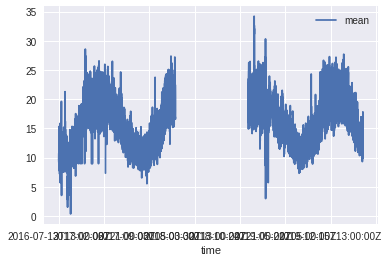

In [8]:
demand_mean_df.plot()

## Preprocessing Pipeline

In [9]:
# preprocessing pipeline
pre_pipeline = Pipeline([
    ('date_worker', mytransformers.DateTransformer()),
    ('shifter', mytransformers.Shifter())
])

In [10]:
# apply pipeline
processed_data = pre_pipeline.fit_transform(demand_df, shifter__days = 7)
features = processed_data[0]
labels = processed_data[0]

time  Total  year  month  day  hour  \
datetime                                                                   
2016-07-13 13:08:57  2016-07-13T13:08:57Z   9.58  2016      7   13    13   
2016-07-13 13:09:57  2016-07-13T13:09:57Z   9.04  2016      7   13    13   
2016-07-13 13:10:57  2016-07-13T13:10:57Z   9.04  2016      7   13    13   
2016-07-13 13:11:57  2016-07-13T13:11:57Z   9.04  2016      7   13    13   
2016-07-13 13:12:57  2016-07-13T13:12:57Z   9.68  2016      7   13    13   

                     minute  day_of_week  
datetime                                  
2016-07-13 13:08:57       8            2  
2016-07-13 13:09:57       9            2  
2016-07-13 13:10:57      10            2  
2016-07-13 13:11:57      11            2  
2016-07-13 13:12:57      12            2  


In [11]:
features.head()

,time,Total,year,month,day,hour,minute,day_of_week,1dayback,2dayback,3dayback,4dayback,5dayback,6dayback,7dayback
datetime,,,,,,,,,,,,,,,
2018-12-07 11:40:00,2018-12-07T11:40:00Z,21.30,2018,12,7,11,40,4,21.87,22.54,22.93,19.98,20.98,19.55,20.54
2018-12-07 11:50:00,2018-12-07T11:50:00Z,21.62,2018,12,7,11,50,4,21.61,22.51,23.15,20.96,20.92,18.89,20.59
2018-12-07 12:00:00,2018-12-07T12:00:00Z,22.27,2018,12,7,12,0,4,22.37,22.90,23.92,21.15,21.60,20.54,21.50
2018-12-07 12:10:00,2018-12-07T12:10:00Z,23.73,2018,12,7,12,10,4,24.26,25.22,25.86,22.49,23.59,21.87,22.59
2018-12-07 12:20:00,2018-12-07T12:20:00Z,23.29,2018,12,7,12,20,4,23.82,24.58,25.36,22.11,22.83,21.30,22.53


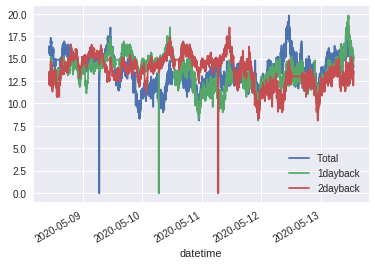

In [31]:
features[['Total', '1dayback', '2dayback']].iloc[-7000:].plot()
plt.savefig('1dayback.png')

In [32]:
trustworthy_test_df = features.groupby(['year', 'month', 'day', 'hour']).count()

In [33]:
trustworthy_test_df[trustworthy_test_df['minute'] != 60]

time  Total  minute  day_of_week  1dayback  2dayback  \
year month day hour                                                         
2018 12    7   11       2      2       2            2         2         2   
               12       6      6       6            6         6         6   
               13       6      6       6            6         6         6   
               14       6      6       6            6         6         6   
               15       6      6       6            6         6         6   
...                   ...    ...     ...          ...       ...       ...   
2020 5     13  0       58     58      58           58        58        58   
               1       34     34      34           34        34        34   
               2       16     16      16           16        16        16   
               3       59     59      59           59        59        59   
               13       9      9       9            9         9         9   

                     3dayback  4dayback  5dayback  6dayback  7dayback  
year month day hour                                                    
2018 12    7   11           2         2         2         2         2  
               12           6         6         6         6         6  
               13           6         6         6         6         6  
               14           6         6         6         6         6  
               15           6         6         6         6         6  
...                       ...       ...       ...       ...       ...  
2020 5     13  0           58        58        58        58        58  
               1           34        34        34        34        34  
               2           16        16        16        16        16  
               3           59        59        59        59        59  
               13           9         9         9         9         9  

[3212 rows x 11 columns]

In [34]:
trustworthy_test_df[trustworthy_test_df['minute'] == 60]

time  Total  minute  day_of_week  1dayback  2dayback  \
year month day hour                                                         
2019 4     3   13      60     60      60           60        60        60   
               14      60     60      60           60        60        60   
               15      60     60      60           60        60        60   
               16      60     60      60           60        60        60   
               17      60     60      60           60        60        60   
...                   ...    ...     ...          ...       ...       ...   
2020 5     13  8       60     60      60           60        60        60   
               9       60     60      60           60        60        60   
               10      60     60      60           60        60        60   
               11      60     60      60           60        60        60   
               12      60     60      60           60        60        60   

                     3dayback  4dayback  5dayback  6dayback  7dayback  
year month day hour                                                    
2019 4     3   13          60        60        60        60        60  
               14          60        60        60        60        60  
               15          60        60        60        60        60  
               16          60        60        60        60        60  
               17          60        60        60        60        60  
...                       ...       ...       ...       ...       ...  
2020 5     13  8           60        60        60        60        60  
               9           60        60        60        60        60  
               10          60        60        60        60        60  
               11          60        60        60        60        60  
               12          60        60        60        60        60  

[6802 rows x 11 columns]

So most of the time it is correct, but I don't think I can trust this.

## Explorations

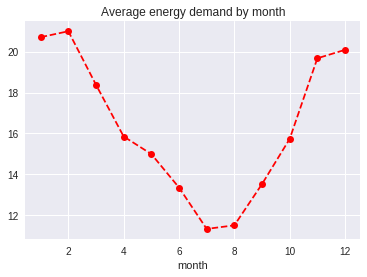

In [44]:
# plot average year
features.groupby(['month']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by month')
plt.savefig('monthly_seasonality.png')

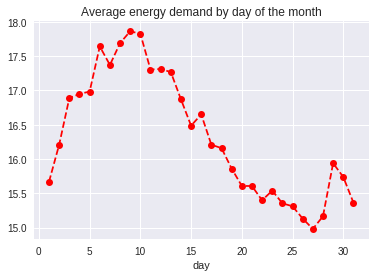

In [45]:
# plot average month
features.groupby(['day']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the month')
plt.savefig('daily_seasonality.png')

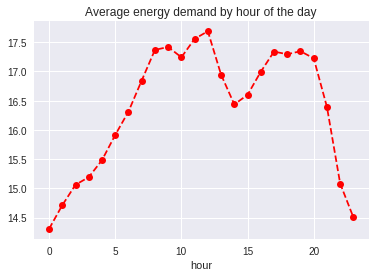

In [46]:
# plot average day
features.groupby(['hour']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by hour of the day')
plt.savefig('hourly_seasonality.png')

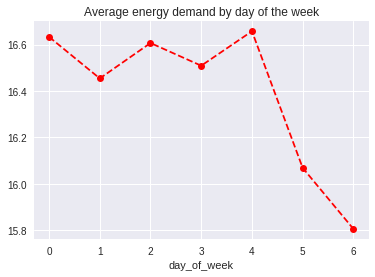

In [48]:
features.groupby(['day_of_week']).mean()['Total'].plot(style = 'o--', c = 'r')
plt.title('Average energy demand by day of the week')
plt.savefig('weekly_seasonality.png')